In [59]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import combinations
import os

from nonlin_coint.data_process import *
from nonlin_coint.FuncCoint import *
from nonlin_coint.VECM import *

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = get_data()
data.head()

,FEX,ITOT,IVV,IWB,IWV,IYY,MGC,RSP,SCHB,SPY,VONE,VOO,VTI,VV
date,,,,,,,,,,,,,,
2010-09-22,21.144136,20.873643,90.558579,50.741136,54.597908,23.084087,30.925452,34.288372,10.859304,89.726950,41.563576,82.609815,46.495789,41.490214
2010-09-23,20.980699,20.704800,89.814934,50.334577,54.122175,22.887941,30.651482,34.025374,10.766678,88.999137,41.135668,81.932662,46.095653,41.146923
2010-09-24,21.452185,21.130175,91.584222,51.363633,55.282227,23.372751,31.245349,34.814368,10.998844,90.834496,41.991484,83.591679,47.069584,41.966030
2010-09-27,21.347790,21.040206,91.162651,51.169165,55.077993,23.279049,31.102022,34.682869,10.950727,90.399387,42.064148,83.193016,46.868501,41.797524
2010-09-28,21.512083,21.154091,91.568313,51.363633,55.355752,23.401270,31.229424,34.929430,11.006864,90.715829,41.838083,83.735197,47.132322,42.006150


In [5]:
tickers = ['MGC', 'VONE', 'VOO', 'RSP', 'SPY', 'VV', 'IWV', 'FEX', 'IVV', 'ITOT', 'IYY', 'IWB', 'VTI', 'SCHB']
years = data.index.year.unique()

Sample

## I(0) Stationary Covariates

- Two index are used: S&P500 and VIX
- Return series of S&P500 is stationary
- Differenced series of VIX is stationary

In [213]:
sp500_ret = pd.read_csv('./data/sp500.csv', parse_dates=['Date'], index_col='Date')['Price'].sort_index().str.replace(',','').astype(float).pct_change()
vix_diff = pd.read_csv('./data/vix.csv', parse_dates=['Date'], index_col='Date')['Price'].sort_index().diff()
covariate = pd.concat([sp500_ret, vix_diff], axis=1).dropna()
covariate.columns = ['sp500_ret', 'vix_diff']

In [214]:
covariate

,sp500_ret,vix_diff
Date,,
2010-01-05,0.003116,-0.69
2010-01-06,0.000546,-0.19
2010-01-07,0.004001,-0.10
2010-01-08,0.002882,-0.93
2010-01-11,0.001747,-0.58
...,...,...
2023-10-02,0.000079,0.09
2023-10-03,-0.013744,2.17
2023-10-04,0.008110,-1.20


In [9]:
def adf_valid_test(y):
    adf_res = ts.adfuller(y, regression = 'n')
    print(adf_res)
    res = [adf_res[0]] + list(adf_res[4].values())
    return res

In [10]:
a = adf_valid_test(covariate['sp500_ret'])
b = adf_valid_test(covariate['vix_diff'])
pd.DataFrame([a,b], columns=['ADF', '1%', '5%', '10%'], index=['S&P500', 'VIX']).to_latex('./writeups/tables/covariate_adf.tex')

(-12.591784700967887, 5.664419425990532e-23, 26, 3436, {'1%': -2.5663910057007837, '5%': -1.9410784565459218, '10%': -1.6167429300708853}, -21316.934723363775)
(-14.126148339307488, 1.7621890049855237e-25, 25, 3437, {'1%': -2.566390816200398, '5%': -1.9410784336364233, '10%': -1.6167429524279888}, 13849.797425082019)


<Axes: xlabel='Date'>

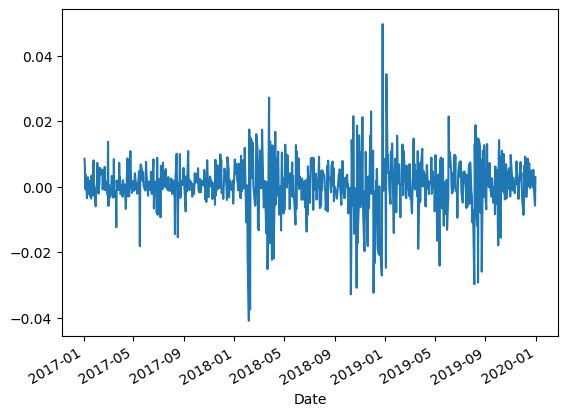

In [212]:
covariate['sp500_ret']['2017':'2019'].plot()

<Axes: xlabel='Date'>

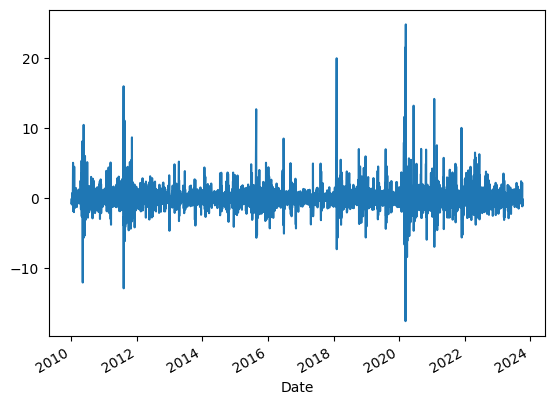

In [12]:
covariate['vix_diff']['2017':'2019'].plot()

## Functional Coefficient Model

### Kernel Estimation

0.9999910284369793


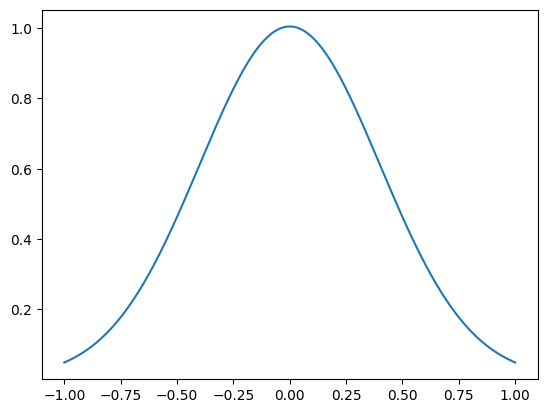

In [43]:
u = np.linspace(-1, 1, int(1e5))
plt.plot(u, normal_pdf(u))
print(normal_pdf(u).sum() * (2/len(u)))

### Test Functional Coefficient Model

#### SPY and VV

In [197]:
y = 2019
pair = ['VV', 'SPY']
price_in, price_out, ret_in, ret_out = get_pair_data(y, data, pair)

x_train, y_train = price_in[pair[0]], price_in[pair[1]]
x_test, y_test = price_out[pair[0]], price_out[pair[1]]
z_train, z_test = covariate.loc[price_in.index], covariate.loc[price_out.index]

In [198]:
stability_test(x_train, y_train, z_train.sp500_ret), coint_test(x_train, y_train, z_train.sp500_ret)

((1139.6361679767174,
  0.0,
  [8.697626145841468, 8.895883046787215, 12.800746371576134]),
 (-1.1045989043922133,
  0.13466671301900668,
  array([-2.32634787, -1.64485363, -1.28155157])))

In [199]:
stability_test(x_train, y_train, z_train.vix_diff), coint_test(x_train, y_train, z_train.vix_diff)

((1532.0420485571167,
  0.0,
  [9.244386017327477, 11.05621410856075, 10.706809916542994]),
 (-1.2622277742289156,
  0.10343341865880462,
  array([-2.32634787, -1.64485363, -1.28155157])))

In [200]:
a = ['S&P500', 1447.15, 7.75, 12.93, 9.22]
b = ['S&P500', -1.26, -2.32, -1.64, -1.28]
c = ['VIX', 1862.94, 8.03, 8.97, 11.70]
d = ['VIX', -1.43, -2.32, -1.64, -1.28]
kk = pd.DataFrame([a,b,c,d], columns=['Covariate','Test Statistics', '1%', '5%', '10%'], index=['Stability', 'Cointegration', 'Stability','Cointegration'])
kk.reset_index(names = 'Type').set_index(['Covariate', 'Type']).to_latex('./writeups/covariate_test.tex')

[14.52099792 -6.79949847]
(0.5080874832070076, 0.009415739237778695)


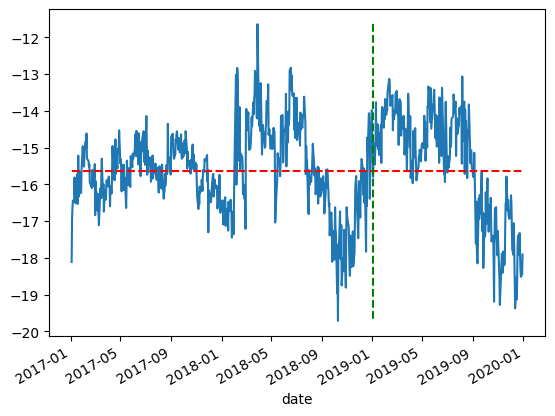

date
2017-01-03   -18.111840
2017-01-04   -16.943545
2017-01-05   -16.633634
2017-01-06   -16.444536
2017-01-09   -16.473075
                ...    
2019-12-24   -17.324825
2019-12-26   -18.335245
2019-12-27   -18.516121
2019-12-30   -18.450522
2019-12-31   -17.910513
Length: 754, dtype: float64

In [201]:
common_trend_vecm(price_in, price_out)

<Axes: xlabel='date'>

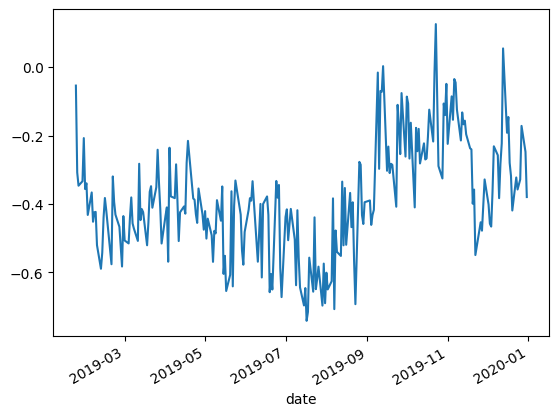

In [202]:
jump = 14
beta = kernel_regresssion(z_test.vix_diff.shift(jump), x_train, y_train, z_train.vix_diff)
hedge_ratio = pd.DataFrame(np.array([-beta, np.ones(len(beta))]).T[jump:], index = x_test.index[jump:], columns = ['x', 'y'])
(price_out.iloc[jump:] * hedge_ratio.values).sum(axis=1).plot()

In [ ]:
a = [-3.19, -3.45, -2.87, -2.57]
b = [-2.4, -3.45, -2.87, -2.57]
pd.DataFrame([a,b], columns=['ADF', '1%', '5%', '10%'], index=['S&P500', 'VIX']).to_latex('./writeups/spread_adf.tex')

#### SPY and IVV

In [203]:
y = 2019
pair = ['SPY', 'IVV']
price_in, price_out, ret_in, ret_out = get_pair_data(y, data, pair)

x_train, y_train = price_in[pair[0]], price_in[pair[1]]
x_test, y_test = price_out[pair[0]], price_out[pair[1]]
z_train, z_test = covariate.loc[price_in.index], covariate.loc[price_out.index]

In [156]:
stability_test(x_train, y_train, z_train.sp500_ret), coint_test(x_train, y_train, z_train.sp500_ret)

((1918.9190160597161,
  0.0,
  [9.922646806773148, 12.941629934634289, 16.831807399873025]),
 (2.142301753917148,
  0.016084603900658467,
  array([-2.32634787, -1.64485363, -1.28155157])))

In [157]:
stability_test(x_train, y_train, z_train.vix_diff), coint_test(x_train, y_train, z_train.vix_diff)

((1606.3904670860334,
  0.0,
  [8.089905027910126, 8.827177229837773, 8.882532967930615]),
 (2.179951135789034,
  0.014630541922317497,
  array([-2.32634787, -1.64485363, -1.28155157])))

[ 19.32512161 -18.99007451]
(0.3956103970517326, 0.10654509682836483)


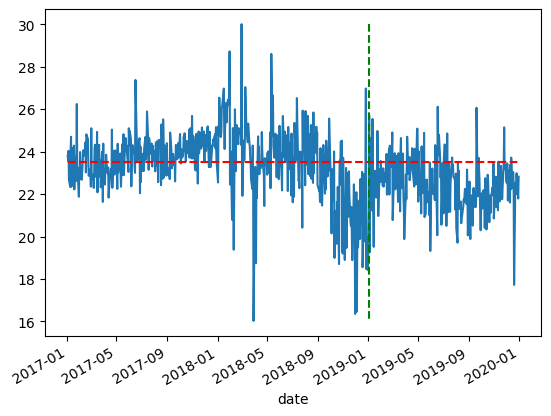

date
2017-01-03    23.799099
2017-01-04    23.562044
2017-01-05    24.040080
2017-01-06    22.661917
2017-01-09    22.334121
                ...    
2019-12-24    21.994019
2019-12-26    22.979706
2019-12-27    22.602495
2019-12-30    21.789001
2019-12-31    22.818567
Length: 754, dtype: float64

In [174]:
common_trend_vecm(price_in, price_out)

OLS beta may generate better result this case

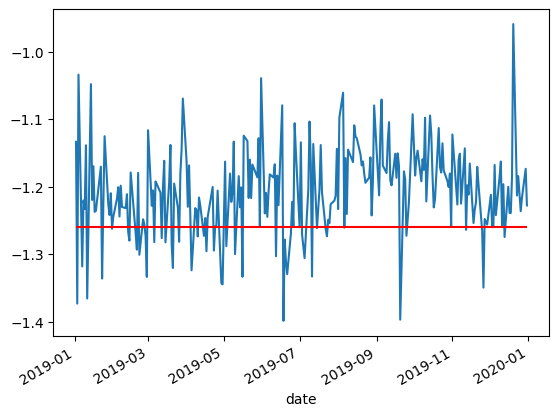

In [173]:
beta_old = price_in.cov().iloc[0,1]/price_in.var().iloc[0]
(price_out @ [-beta_old, 1]).plot()
plt.hlines((price_in @ [-beta_old, 1]).mean(), price_out.index[0], price_out.index[-1], color='r')

In [207]:
beta = kernel_regresssion(z_test.sp500_ret.shift(1), x_train, y_train, z_train.sp500_ret)

<Axes: xlabel='date'>

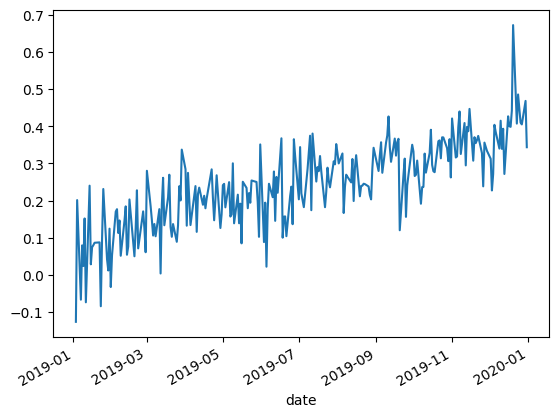

In [208]:
hedge_ratio = pd.DataFrame(np.array([-beta, np.ones(len(beta))]).T[1:], index = x_test.index[1:], columns = ['x', 'y'])
(price_out.iloc[1:] * hedge_ratio.values).sum(axis=1).plot()

In [209]:
# (price_out.iloc[1:] * hedge_ratio.values).sum(axis=1).plot()
# plt.hlines((price_in @ hedge_ratio.iloc[0].values).mean(), price_out.index[0], price_out.index[-1], color='r')

<Axes: xlabel='date'>

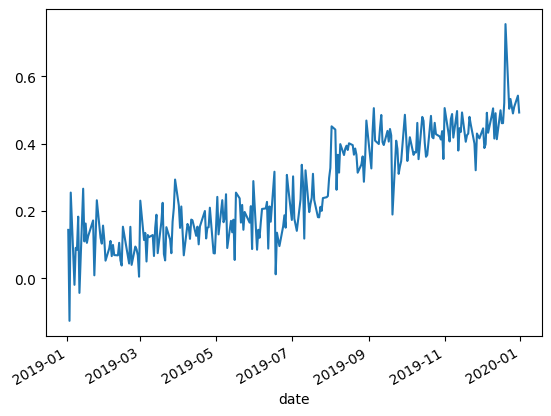

In [210]:
hedge_ratio_base = pd.DataFrame(index = price_out.index)
hedge_ratio_monthly = pd.merge_asof(hedge_ratio_base, hedge_ratio.resample('6M').first(), left_index=True, right_index=True, direction='forward')
beta_spread = (price_out * hedge_ratio_monthly.values).sum(axis=1)
beta_spread.plot()